# Telecom Churn Prediction - Starter Notebook

**Author:** Harish Babu (www.harishbabu.in)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [153]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score


# LightGBM Learning Algo
import lightgbm as gbm

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [4]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [259]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

df = pd.read_csv("./train.csv")
unseen = pd.read_csv("./test.csv")
sample = pd.read_csv("./sample.csv")
data_dict = pd.read_csv("./data_dictionary.csv")

print(df.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [387]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


# 2. Data Pre-processing

### 2.1 Handling Missing Values

Let us look at missing percentage across columns

In [260]:
# Find the top 10 columns that have missing values.
percent_missing = (df.isnull().sum() / df.isnull().count()*100).sort_values(ascending = False)
percent_missing.head(32)

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
total_rech_data_6           74.902499
av_rech_amt_data_6          74.902499
max_rech_data_6             74.902499
count_rech_3g_6             74.902499
fb_user_6                   74.902499
night_pck_user_7            74.478207
date_of_last_rech_data_7    74.478207
total_rech_data_7           74.478207
max_rech_data_7             74.478207
fb_user_7                   74.478207
count_rech_2g_7             74.478207
count_rech_3g_7             74.478207
arpu_3g_7                   74.478207
av_rech_amt_data_7          74.478207
arpu_2g_7                   74.478207
count_rech_2g_8             73.689624
av_rech_amt_data_8          73.689624
night_pck_user_8            73.689624
max_rech_data_8             73.689624
total_rech_data_8           73.689624
arpu_2g_8                   73.689624
arpu_3g_8   

In [261]:
# There are so many columns that have significant count of missing values.  
# Since they will not really be helpful in predictions, we can drop them

cols_to_drop = percent_missing[percent_missing.gt(40)].index
cols_to_drop

Index(['arpu_3g_6', 'count_rech_2g_6', 'night_pck_user_6', 'arpu_2g_6',
       'date_of_last_rech_data_6', 'total_rech_data_6', 'av_rech_amt_data_6',
       'max_rech_data_6', 'count_rech_3g_6', 'fb_user_6', 'night_pck_user_7',
       'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7',
       'fb_user_7', 'count_rech_2g_7', 'count_rech_3g_7', 'arpu_3g_7',
       'av_rech_amt_data_7', 'arpu_2g_7', 'count_rech_2g_8',
       'av_rech_amt_data_8', 'night_pck_user_8', 'max_rech_data_8',
       'total_rech_data_8', 'arpu_2g_8', 'arpu_3g_8',
       'date_of_last_rech_data_8', 'fb_user_8', 'count_rech_3g_8'],
      dtype='object')

In [262]:
df.drop(cols_to_drop,axis=1,inplace=True)
df.shape

(69999, 142)

In [263]:
## Have we solved the problem?
percent_missing = (df.isnull().sum() / df.isnull().count()*100).sort_values(ascending = False)
percent_missing.head(20)

roam_og_mou_8       5.290076
og_others_8         5.290076
spl_og_mou_8        5.290076
loc_ic_t2t_mou_8    5.290076
loc_og_t2m_mou_8    5.290076
loc_og_t2c_mou_8    5.290076
loc_ic_t2m_mou_8    5.290076
loc_og_t2t_mou_8    5.290076
loc_ic_t2f_mou_8    5.290076
std_og_t2f_mou_8    5.290076
loc_ic_mou_8        5.290076
isd_og_mou_8        5.290076
roam_ic_mou_8       5.290076
std_ic_t2t_mou_8    5.290076
loc_og_mou_8        5.290076
offnet_mou_8        5.290076
std_ic_t2m_mou_8    5.290076
onnet_mou_8         5.290076
std_ic_t2f_mou_8    5.290076
std_og_mou_8        5.290076
dtype: float64

##### The highest percentage of null values is ~5% now.  Which should be okay.

### 2.2 Dropping Columns with low variance

In [264]:
df.nunique().sort_values().head(20)

std_ic_t2o_mou_7         1
circle_id                1
loc_og_t2o_mou           1
std_og_t2o_mou           1
loc_ic_t2o_mou           1
last_date_of_month_6     1
last_date_of_month_7     1
last_date_of_month_8     1
std_og_t2c_mou_7         1
std_ic_t2o_mou_8         1
std_ic_t2o_mou_6         1
std_og_t2c_mou_8         1
std_og_t2c_mou_6         1
churn_probability        2
monthly_2g_6             5
monthly_2g_8             6
monthly_2g_7             6
monthly_3g_6            10
monthly_3g_8            12
monthly_3g_7            13
dtype: int64

In [265]:
# There are quite a few columns with only one value.  They have low variance and do not add value to the model
# We can drop them

df = df.loc[:, df.nunique() > 1]

In [266]:
df.shape

(69999, 129)

In [267]:
df.duplicated().sum()

0

&#x2139; —  **Note** 
     
📍 No more duplicates

### 2.3 Imputing Values

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [268]:
missing_data_percent = df.isnull().any()

impute_cols = missing_data_percent[missing_data_percent.gt(0)].drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']).index
print("No. of columns that need values imputed ", impute_cols.shape)
print(impute_cols)

No. of columns that need values imputed  (81,)
Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'lo

In [269]:
# Impute values with a simple imputer.  Fill contant value of zer everywhere.
imp = SimpleImputer(strategy='constant', fill_value=0)
df[impute_cols] = imp.fit_transform(df[impute_cols])

In [277]:
df.shape

(69999, 129)

# 3. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

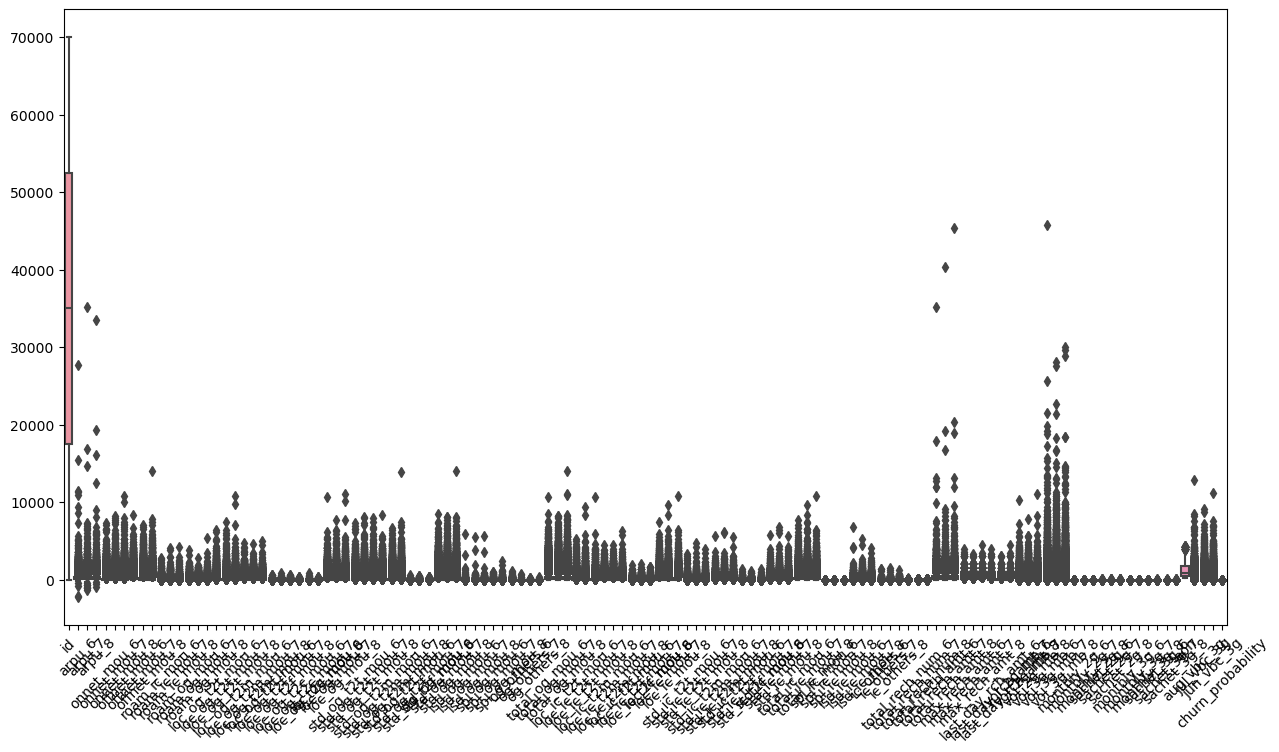

In [271]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = df)

### 3.1 Derived Features

#### Last Recharge Dates    
      
The last recharge dates are not very relevant as such.  It makes sense to convert them in to something else.  I have converted them in to months since last recharge.


In [278]:
df.shape

(69999, 129)

In [279]:
from datetime import datetime

def calculate_latest_charge_date(date_6, date_7, date_8):
    # Function to check if a date string is valid
    def is_valid_date(date_str):
        try:
            datetime.strptime(date_str, '%m/%d/%Y')
            return True
        except ValueError:
            return False

    # Check conditions and calculate months_since_last_charge
    if date_8 and not pd.isna(date_8) and is_valid_date(date_8):
        months_since_last_charge = 0
    elif date_7 and not pd.isna(date_7) and is_valid_date(date_7):
        months_since_last_charge = 1
    elif date_6 and not pd.isna(date_6) and is_valid_date(date_6):
        months_since_last_charge = 2
    else:
        months_since_last_charge = 3

    return months_since_last_charge



# Function to calculate months_since_last_charge
def calculate_months_since_last_charge_df(row):
    return calculate_latest_charge_date(row['date_of_last_rech_6'], row['date_of_last_rech_7'], row['date_of_last_rech_8'])


In [280]:
# Split data in to categorical & numerical variables
df_categorical_fields = df.select_dtypes(include=['object'])
df_categorical_fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date_of_last_rech_6  68898 non-null  object
 1   date_of_last_rech_7  68765 non-null  object
 2   date_of_last_rech_8  67538 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [281]:
df_categorical_fields['months_since_last_charge'] = df_categorical_fields.apply(calculate_months_since_last_charge_df, axis=1)

In [282]:
# Drop the last recharge date columns
df_categorical_fields.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)

In [283]:
df_categorical_fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   months_since_last_charge  69999 non-null  int64
dtypes: int64(1)
memory usage: 547.0 KB


### 3.2 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [284]:
df_numerical_variables = df.select_dtypes(include=['int64', 'float64'])
df_numerical_variables.pop('id')                   # Remove id variable.  Though it is numeric, it does not need outlier treatment
df_numerical_variables.pop('churn_probability')    # Remove churn_probability variable. It does not need outlier treatment
df_numerical_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 124 entries, arpu_6 to jun_vbc_3g
dtypes: float64(99), int64(25)
memory usage: 66.2 MB


<Axes: >

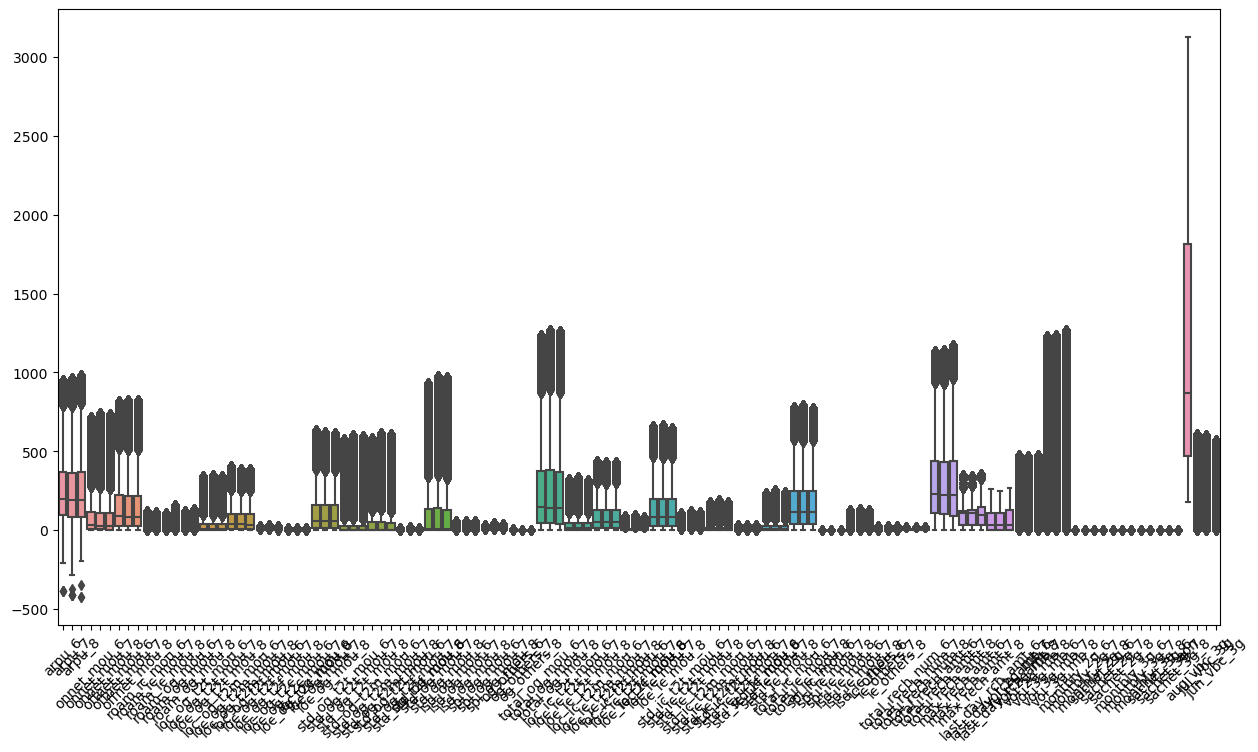

In [285]:
# Apply the capping to the 
# Let us cap the values
# But exclude the id field.  It is numerical, but should not be capped.

def col_clip(col):
    mean = col.mean()
    std = col.std()
    return col.clip(mean - 2 * std, mean + 2 * std)


df_numerical_variables = df_numerical_variables.apply(col_clip, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = df_numerical_variables)

In [286]:
df_numerical_variables.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 124 columns):
 #    Column              Dtype  
---   ------              -----  
 0    arpu_6              float64
 1    arpu_7              float64
 2    arpu_8              float64
 3    onnet_mou_6         float64
 4    onnet_mou_7         float64
 5    onnet_mou_8         float64
 6    offnet_mou_6        float64
 7    offnet_mou_7        float64
 8    offnet_mou_8        float64
 9    roam_ic_mou_6       float64
 10   roam_ic_mou_7       float64
 11   roam_ic_mou_8       float64
 12   roam_og_mou_6       float64
 13   roam_og_mou_7       float64
 14   roam_og_mou_8       float64
 15   loc_og_t2t_mou_6    float64
 16   loc_og_t2t_mou_7    float64
 17   loc_og_t2t_mou_8    float64
 18   loc_og_t2m_mou_6    float64
 19   loc_og_t2m_mou_7    float64
 20   loc_og_t2m_mou_8    float64
 21   loc_og_t2f_mou_6    float64
 22   loc_og_t2f_mou_7    float64
 23   loc_og_t2f_mou_8    float64
 24   

In [287]:
df_numerical_variables.shape

(69999, 124)

In [288]:
# Now concatenate all the dataframes and then include the id field also

In [289]:
id_df = df[['id','churn_probability']]

In [290]:
df = pd.concat([df_numerical_variables, df_categorical_fields, id_df], axis=1)

In [291]:
df.set_index('id')

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,months_since_last_charge,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0.0000,0.0,0.0,0.0,1958.0,0.000000,0.000000,0.00000,0,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0.0000,0.0,0.0,0.0,710.0,0.000000,0.000000,0.00000,0,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0.0000,0.0,0.0,0.0,882.0,0.000000,0.000000,0.00000,0,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0.0000,0.0,0.0,0.0,982.0,0.000000,0.000000,0.00000,0,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0.0000,0.0,1.0,0.0,647.0,0.000000,0.000000,0.00000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0.0000,0.0,1.0,0.0,221.0,0.000000,0.000000,0.00000,0,0
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0.0000,0.0,0.0,0.0,712.0,0.000000,0.000000,0.00000,0,0
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0.0000,0.0,0.0,0.0,879.0,0.000000,0.000000,0.00000,0,0


In [292]:
df.shape

(69999, 127)

# 4. Preliminary Model Building Using LightGBM






First lets create X and y datasets.

Splitting train and test data to avoid any contamination of the test data

In [293]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.shape, df_test.shape

((55999, 127), (14000, 127))

### 4.1 Feature scaling & Imbalance Correction

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [294]:
df_train['churn_probability'] = df_train.churn_probability.apply(np.int64)

In [295]:
df_train['churn_probability'].value_counts()

churn_probability
0    50289
1     5710
Name: count, dtype: int64

In [296]:
scaler = MinMaxScaler()
cols_to_scale = df_train.drop(['id'], axis=1).columns
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])

In [297]:
df_train.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,months_since_last_charge,id,churn_probability
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,...,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,0.488810,0.489696,0.489120,0.147485,0.143850,0.141483,0.208004,0.204165,0.200885,0.048642,...,0.036336,0.034025,0.033299,0.347750,0.079535,0.075546,0.071853,0.014649,34968.080162,0.101966
std,0.179125,0.174850,0.173412,0.244177,0.243840,0.242064,0.254495,0.255085,0.254190,0.173262,...,0.174798,0.165883,0.161926,0.311571,0.233536,0.228976,0.224056,0.082580,20195.580237,0.302606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.358020,0.361285,0.361806,0.007492,0.006683,0.005585,0.035381,0.032586,0.029087,0.000000,...,0.000000,0.000000,0.000000,0.097777,0.000000,0.000000,0.000000,0.000000,17483.000000,0.000000
50%,0.435749,0.437405,0.438132,0.042876,0.039439,0.037748,0.109621,0.104202,0.101038,0.000000,...,0.000000,0.000000,0.000000,0.233577,0.000000,0.000000,0.000000,0.000000,34969.000000,0.000000
75%,0.565110,0.563718,0.564539,0.157335,0.147153,0.145035,0.273698,0.264799,0.262176,0.000000,...,0.000000,0.000000,0.000000,0.552030,0.000000,0.000000,0.000000,0.000000,52457.500000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,69998.000000,1.000000


In [298]:
y_train = df_train.pop('churn_probability')
X_train = df_train

In [299]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN



# Specify the desired ratio using the sampling_strategy parameter
desired_ratio = {0: 50289, 1: 15456}  # Adjust the numbers based on your desired ratio


smote = SMOTEENN(sampling_strategy=desired_ratio, random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)

In [300]:
y_train.value_counts()

churn_probability
0.0    24843
1.0     3344
Name: count, dtype: int64

### 4.2 Building an preliminary model with LightGBM 


Now we build a model with light GBM to see how the model performs.  We can do PCA later.

In [188]:
y_train.info(verbose=True)

<class 'pandas.core.series.Series'>
Index: 55999 entries, 47338 to 15795
Series name: churn_probability
Non-Null Count  Dtype  
--------------  -----  
55999 non-null  float64
dtypes: float64(1)
memory usage: 875.0 KB


In [189]:
# Hyper-parameters
param = {
    'num_leaves': 150,
    'max_depth':7,
    'learning_rate':.05,
    'max_bin':200,
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt'
}

In [190]:
lgb_classifier = gbm.LGBMClassifier(random_state=42, **param)

In [191]:
lgb_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5710, number of negative: 50289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20731
[LightGBM] [Info] Number of data points in the train set: 55999, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101966 -> initscore=-2.175567
[LightGBM] [Info] Start training from score -2.175567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(learning_rate=0.05, max_bin=200, max_depth=7,
               metric=['auc', 'binary_logloss'], num_leaves=150,
               random_state=42)

In [192]:
lgb_classifier.feature_importances_

array([167, 216, 116,  72,  57,  94,  70,  65, 115,  51,  71, 158,  55,
        71, 188,  67,  70,  91,  60,  66,  72,  47,  44,  75,  39,  46,
        57,  61,  41,  87,  47,  43,  40,  50,  70,  32,  14,  21,  17,
        40, 112,  40,  55,  47,  86,  48, 111,  66,  53,   0,   0,  73,
        62,  89,  91,  95, 117, 126,  69, 120,  56,  80,  61,  73, 121,
       205,  56,  40,  43,  79,  51,  59,  21,  35,  62,  53,  69,  96,
       122, 156, 249,  26,  23, 150,  59,  52,  70,  43,  53,  43,  93,
       170, 153,  69,  90, 197,  77,  74, 120,  48,  75, 243,  47,  67,
       127,  37,  81, 110,   4,  13,   4,  32,  24,   6,   5,  18,   6,
        13,  22,  14, 352,  40,  37,  35,  24, 205], dtype=int32)

In [193]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": lgb_classifier.feature_importances_
})

In [194]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
120,aon,352
80,total_ic_mou_8,249
101,last_day_rch_amt_8,243
1,arpu_7,216
125,id,205
...,...,...
114,monthly_3g_6,5
110,monthly_2g_8,4
108,monthly_2g_6,4
50,og_others_8,0


**Let us look at the predictions and accuracy**

In [301]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(classifier, X, y):
    print("Train Accuracy :", accuracy_score(y, classifier.predict(X)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y, classifier.predict(X)))

In [196]:
evaluate_model(lgb_classifier, X_train, y_train)

Train Accuracy : 0.956392078429972
Train Confusion Matrix:
[[49354   935]
 [ 1507  4203]]


**Now let us prepare the test data and evaluate the model on that**

In [302]:
df_test['churn_probability'] = df_test.churn_probability.apply(np.int64)

In [303]:
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [304]:
df_test.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,months_since_last_charge,id,churn_probability
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,0.488699,0.487598,0.489729,0.149566,0.142969,0.141272,0.206772,0.200144,0.201592,0.048332,...,0.035828,0.034732,0.033457,0.350978,0.077803,0.075744,0.070077,0.014405,35122.677143,0.101571
std,0.177829,0.174028,0.173539,0.247414,0.243274,0.241877,0.251384,0.252164,0.254652,0.171669,...,0.174605,0.167770,0.161964,0.314339,0.232436,0.230928,0.220516,0.081402,20253.438450,0.302095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,0.358835,0.359599,0.361025,0.007809,0.006390,0.005581,0.034880,0.031077,0.028273,0.000000,...,0.000000,0.000000,0.000000,0.097437,0.000000,0.000000,0.000000,0.000000,17553.750000,0.000000
50%,0.436634,0.436378,0.439799,0.043085,0.039088,0.038095,0.111311,0.100881,0.100249,0.000000,...,0.000000,0.000000,0.000000,0.233238,0.000000,0.000000,0.000000,0.000000,35120.000000,0.000000
75%,0.567125,0.561796,0.565245,0.158376,0.146202,0.141832,0.273508,0.260952,0.266304,0.000000,...,0.000000,0.000000,0.000000,0.563913,0.000000,0.000000,0.000000,0.000000,52639.500000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,69994.000000,1.000000


In [305]:
y_test = df_test.pop('churn_probability')
X_test = df_test

In [201]:
evaluate_model(lgb_classifier, X_test, y_test)

Train Accuracy : 0.9432857142857143
Train Confusion Matrix:
[[12262   316]
 [  478   944]]


### 4.3 Hyperparameter tuning using gridsearch CV


Let us use gridsearch to find the proper hyperparameters


In [370]:
hyperparam_grid = {
    'num_leaves': [5, 20, 49],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [25, 50, 100],
    'max_depth': [ 5, 7 ],
    'max_bin': [ 150, 200, 400 ]
}

In [197]:
param = {
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt'
}

In [198]:
estimator = gbm.LGBMClassifier(objective='binary',random_state=42, **param)

In [ ]:
# Initialize GridSearchCV for hyperparameters
grid_search_cv = GridSearchCV(estimator=estimator, param_grid=hyperparam_grid,
                           scoring='accuracy', cv=5)
 
# Fit the model to the training data to search for the best hyperparameters
grid_search_cv.fit(X_train, y_train)
 
# Get the best hyperparameters and their values
best_params = grid_search_cv.best_params_
best_hyperparameters = list(grid_search_cv.keys())
best_values = list(grid_search_cv.values())

In [200]:
best_params

{'learning_rate': 0.1,
 'max_bin': 200,
 'max_depth': 7,
 'n_estimators': 50,
 'num_leaves': 20}

In [201]:
# Now let us build a model with these parameters

new_params = {
    'learning_rate': 0.1,
    'max_bin': 200,
    'max_depth': 7,
    'n_estimators': 50,
    'num_leaves': 20,
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt'
}

In [204]:
lgb_model_final = gbm.LGBMClassifier(objective='binary',random_state=42, n_jobs=-1, **new_params)

In [205]:
lgb_model_final.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5710, number of negative: 50289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20739
[LightGBM] [Info] Number of data points in the train set: 55999, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101966 -> initscore=-2.175567
[LightGBM] [Info] Start training from score -2.175567


LGBMClassifier(max_bin=200, max_depth=7, metric=['auc', 'binary_logloss'],
               n_estimators=50, n_jobs=-1, num_leaves=20, objective='binary',
               random_state=42)

In [206]:
evaluate_model(lgb_model_final, X_train, y_train)

Train Accuracy : 0.9457133163092198
Train Confusion Matrix:
[[49188  1101]
 [ 1939  3771]]


In [207]:
evaluate_model(lgb_model_final, X_test, y_test)

Train Accuracy : 0.9441428571428572
Train Confusion Matrix:
[[12271   307]
 [  475   947]]


### 4.4 Use PCA to find reduce dimensionality

In [306]:
pca_again = PCA(0.9,random_state=42)

In [307]:
pca_again.fit(X_train.drop('id', axis=1))

PCA(n_components=0.9, random_state=42)

In [308]:
pca_again.components_

array([[ 0.11911319,  0.12691264,  0.12166773, ...,  0.03851222,
         0.03479985, -0.01060134],
       [ 0.04731959,  0.05818474,  0.04670758, ..., -0.05977362,
        -0.05653767, -0.00158142],
       [ 0.05889681,  0.06644969,  0.06937413, ...,  0.26805562,
         0.24623519, -0.00547804],
       ...,
       [ 0.10154074,  0.06798816,  0.11457201, ..., -0.01470603,
         0.02857154,  0.00947888],
       [ 0.00802709,  0.05579517, -0.02695868, ..., -0.07591957,
         0.07228016,  0.008102  ],
       [-0.0253552 ,  0.00938289, -0.01353789, ...,  0.00662724,
         0.05742288,  0.00595741]])

In [309]:
var_cumu = np.cumsum(pca_again.explained_variance_ratio_)

In [310]:
pca_again.explained_variance_ratio_

array([0.2114224 , 0.11413166, 0.0633027 , 0.04088244, 0.03927112,
       0.03582078, 0.03380125, 0.02579968, 0.02229082, 0.02032829,
       0.01811233, 0.01621343, 0.01555916, 0.01545509, 0.01470107,
       0.0143924 , 0.01219457, 0.01089342, 0.01041188, 0.00993523,
       0.00947308, 0.00914778, 0.00885887, 0.00861125, 0.00851272,
       0.00828716, 0.00762168, 0.00695562, 0.00668169, 0.00661793,
       0.00639392, 0.00632215, 0.00595515, 0.00585998, 0.00578412,
       0.00542774, 0.00532408, 0.0050859 , 0.00494644, 0.0048683 ,
       0.00479095, 0.00471104, 0.00440654, 0.00429186, 0.00379764])

In [311]:
def plot_cum_variance_explained(var_cumu):
    fig = plt.figure(figsize=[12,8])
    plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
    plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
    plt.plot(var_cumu)
    plt.ylabel("Cumulative variance explained")
    plt.show()


In [312]:
X_train_pca_transformed = pca_again.transform(X_train.drop('id', axis=1))

In [313]:
X_train_pca_transformed.shape

(28187, 45)

In [314]:
corrmat = np.corrcoef(X_train_pca_transformed.transpose())

<Axes: >

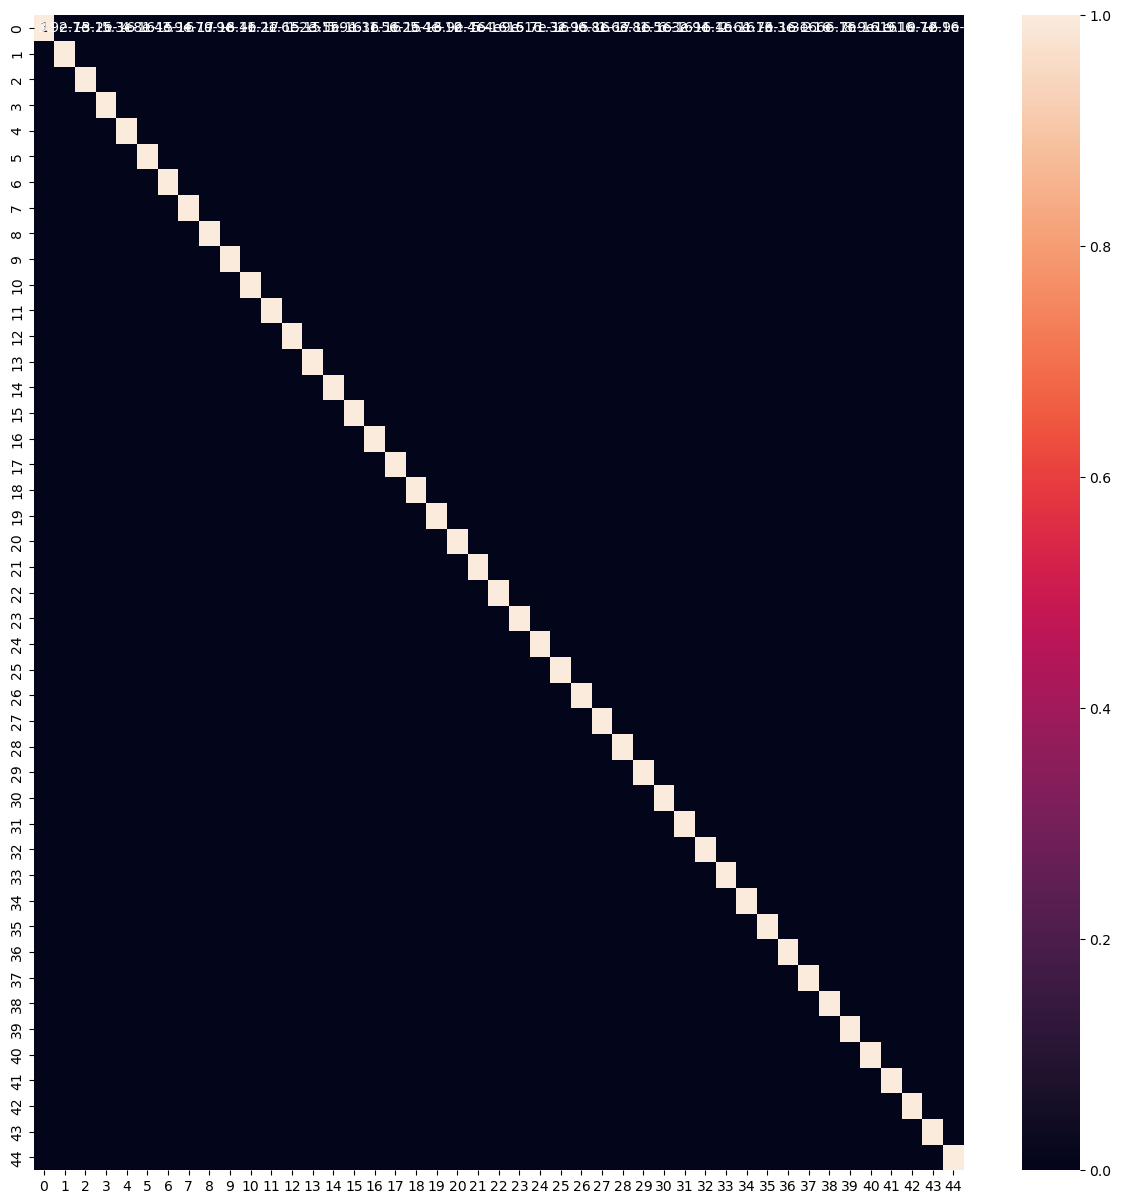

In [315]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

#### Let us try building a final lgbm classifier with the PCs

In [316]:
# Hyper-parameters
param = {
    'num_leaves': 150,
    'max_depth':7,
    'learning_rate':.05,
    'max_bin':200,
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt'
}

In [317]:
lgb_classifier_after_pca = gbm.LGBMClassifier(random_state=42, **param)

In [318]:
lgb_classifier_after_pca.fit(X_train_pca_transformed, y_train)

[LightGBM] [Info] Number of positive: 3344, number of negative: 24843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9000
[LightGBM] [Info] Number of data points in the train set: 28187, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118636 -> initscore=-2.005408
[LightGBM] [Info] Start training from score -2.005408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(learning_rate=0.05, max_bin=200, max_depth=7,
               metric=['auc', 'binary_logloss'], num_leaves=150,
               random_state=42)

In [319]:
evaluate_model(lgb_classifier_after_pca, X_train_pca_transformed, y_train)

Train Accuracy : 0.9633873771596836
Train Confusion Matrix:
[[24491   352]
 [  680  2664]]


In [320]:
X_test_pca_transformed = pca_again.transform(X_test.drop('id', axis=1))

In [321]:
evaluate_model(lgb_classifier_after_pca, X_test_pca_transformed, y_test)

Train Accuracy : 0.9195
Train Confusion Matrix:
[[12227   351]
 [  776   646]]


In [322]:
df_test.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'months_since_last_charge',
       'id'],
      dtype='object', length=126)

#### Let us also try building a logistic regression model with the PCs

In [323]:
learner_pca = LogisticRegression()

In [324]:
model_pca = learner_pca.fit(X_train_pca_transformed, y_train)

In [325]:
evaluate_model(model_pca, X_train_pca_transformed,y_train)

Train Accuracy : 0.913967431794799
Train Confusion Matrix:
[[24226   617]
 [ 1808  1536]]


In [222]:
# Accuracy seems to be lesser than 

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

In [ ]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [ ]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

In [ ]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

In [ ]:
lr.score(pca_components[:,:2], y_train)

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [ ]:
pipe.fit(X_train[new_vars], y_train)

In [ ]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [326]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [327]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [328]:
# Let us create the months_since_last_recharge field here
unseen['months_since_last_charge'] = unseen.apply(calculate_months_since_last_charge_df, axis=1)

In [329]:
unseen[impute_cols] = imp.fit_transform(unseen[impute_cols])

In [330]:
submission_data = unseen[df_test.columns]

In [331]:
submission_data.set_index('id')

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,months_since_last_charge
id,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,...,0,0,0,0,0,1692,0.00,0.00,0.00,0
70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,...,0,0,0,0,0,2533,0.00,0.00,0.00,0
70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,...,0,0,0,0,0,277,525.61,758.41,241.84,0
70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,0.00,...,0,0,0,0,0,1244,0.00,0.00,0.00,0
70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,0.00,...,0,0,0,0,0,462,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,718.870,396.259,406.150,324.46,250.01,285.41,190.36,166.14,221.96,87.76,...,0,0,0,0,0,1255,3.71,105.64,61.48,0
99995,218.327,324.070,374.981,263.79,467.24,650.26,108.53,124.11,189.76,3.40,...,1,0,0,0,0,2258,0.00,0.00,0.00,0
99996,139.473,38.230,180.194,11.08,14.89,19.94,37.24,16.74,45.28,0.00,...,0,0,0,0,0,440,0.00,0.00,0.00,0


In [235]:
df_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,months_since_last_charge,id
57621,1.000000,1.000000,0.601083,0.508537,0.542536,0.225403,0.265128,0.203987,0.070020,0.0,...,0.0,0.0,0.0,0.0,0.166016,0.000000,0.000000,0.000000,0.0,57621
39559,0.675117,0.593761,0.605016,0.156353,0.169961,0.135354,0.277493,0.433635,0.513952,0.0,...,0.0,0.0,0.0,0.0,0.096419,0.177647,1.000000,1.000000,0.0,39559
41415,0.773081,0.724053,0.741383,1.000000,1.000000,1.000000,0.519471,0.267321,0.426874,0.0,...,0.0,0.0,0.0,0.0,0.076388,0.000000,0.000000,0.000000,0.0,41415
47731,0.472161,0.426771,0.396359,0.239710,0.113244,0.114930,0.210281,0.071718,0.028078,0.0,...,0.0,0.0,0.0,0.0,0.359872,0.000000,0.000000,0.000000,0.0,47731
64801,0.955161,0.853870,0.955943,0.661631,0.565627,0.884207,1.000000,0.744994,0.741968,0.0,...,1.0,0.0,0.0,0.0,0.462062,1.000000,0.825032,0.472316,0.0,64801


Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [332]:
pca_submission = PCA(n_components=45,random_state=42)
submission_data_transformed = pca_submission.fit_transform(submission_data.drop('id', axis=1))


In [333]:
pca_submission.explained_variance_ratio_

array([0.27585552, 0.1636976 , 0.12976575, 0.07862663, 0.04948206,
       0.04683023, 0.03606459, 0.02757765, 0.02201304, 0.01902625,
       0.01559238, 0.01427253, 0.01067004, 0.01043482, 0.00933873,
       0.00901835, 0.00814901, 0.00627135, 0.00572218, 0.00562924,
       0.00464912, 0.00425396, 0.00406118, 0.00401136, 0.00386634,
       0.00377193, 0.00279972, 0.00257668, 0.00240912, 0.00209502,
       0.00202943, 0.00182448, 0.0015882 , 0.00146359, 0.00140686,
       0.0013444 , 0.00125545, 0.00090729, 0.00087425, 0.00080713,
       0.00078551, 0.00076416, 0.00073587, 0.00064916, 0.00060874])

In [334]:
var_cumu = np.cumsum(pca_submission.explained_variance_ratio_)

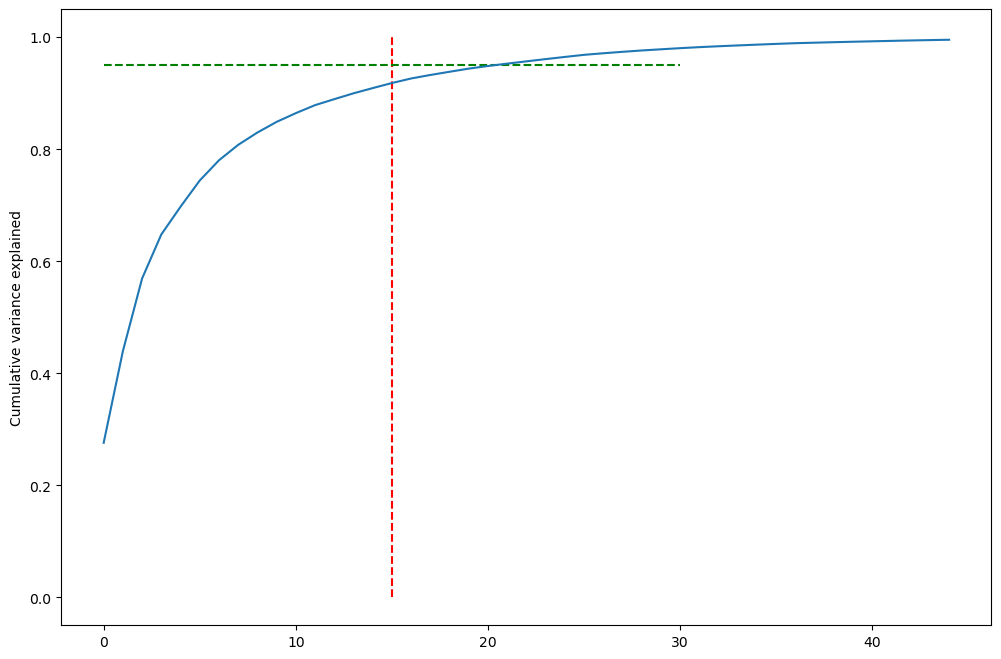

In [335]:
plot_cum_variance_explained(var_cumu)

In [336]:
unseen['churn_probability'] = lgb_classifier_after_pca.predict(submission_data_transformed)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0.0
1,70000,0.0
2,70001,0.0
3,70002,0.0
4,70003,0.0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [338]:
output['churn_probability'] = output.churn_probability.apply(np.int64)

In [339]:
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [340]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

### Appendix A

#### Some additional cells that could be used

In [ ]:
# Correcting imbalance


In [144]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN



# Specify the desired ratio using the sampling_strategy parameter
desired_ratio = {0: 50289, 1: 15456}  # Adjust the numbers based on your desired ratio


smote = SMOTEENN(sampling_strategy=desired_ratio, random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)